## Updated Distribution Score
Changes from Previous Distribition Score File:
- Memorization score is now the relative memorization score, (F1_TR - F1_ Vl / F1_TR + F1_ Vl). Did not observe a major difference in relationship between memorization and distribution from this change.
- Removed data points where the F1_TR score was below 0.5, although this only removed 4 dataponts
- Removed data points where the F1_TR score was above 0.999, removing about 400 datapoints. This removed the cluster where distribution had no effect on memorization.
- Added datapoint color coding by moltype
- Found distribution score for LevenShtein Distance matrix. This clearly needs some work because the relationship modeled is incorrect.
- Added code to calculate influnce score, but I cannot run this code because it takes too long to complie on my laptop (2+ hours at least)

### Loading in all training and evaluation data

In [1]:
import pandas as pd
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

tr_data = []  # Empty list to hold TR data
vl_data = []  # Empty list to hold VL data
memorization_score = []  # Empty list to hold memorization scores

data_path = '/Users/ilanastern/Documents/GitHub/aiConfidential/data' 

# Walk through all directories and subdirectories in the 'data' folder
for root, dirs, files in os.walk(data_path):
    if root.endswith('_TR.eval') or root.endswith('_VL.eval'): # Check if we are in a TR.eval or VL.eval folder
        for file in files:
            if file.startswith('eval_loss_meta'): # Check if the file is 'eval_loss_meta'
                file_path = os.path.join(root, file)
                # Read the file into a DataFrame
                df = pd.read_csv(file_path)
                # Append to the appropriate list
                if root.endswith('_TR.eval'):
                    tr_data.append(df)
                elif root.endswith('_VL.eval'):
                    vl_data.append(df)

# Concatenate all dataframes into one for TR and one for VL
tr_df = pd.concat(tr_data, ignore_index=True)
vl_df = pd.concat(vl_data, ignore_index=True)

### Calculating the RELATIVE memorization score for every index

In [2]:
#Avergaing the f1 scores for each idx in both the TR and VL dataframes
tr_avg_f1 = tr_df.groupby(['idx', 'moltype'])['f1'].mean().reset_index() #Keeping moltype column
tr_avg_f1.rename(columns={'f1': 'tr_avg_f1'}, inplace=True)
vl_avg_f1 = vl_df.groupby(['idx'])['f1'].mean().reset_index()
vl_avg_f1.rename(columns={'f1': 'vl_avg_f1'}, inplace=True)

memscore_df = pd.merge(tr_avg_f1, vl_avg_f1, on='idx')# Combining the TR and VL dataframes into one
# Get memorization score. This time this is the Relative Memscore (TR_F1 - VL_F1)/(TR_F1 + VL_F1), and removes underperfroming models
memscore_df['Memorization_Score'] = (memscore_df['tr_avg_f1'] - memscore_df['vl_avg_f1'])/((memscore_df['tr_avg_f1'] + memscore_df['vl_avg_f1'])) # Subtract the VL F1 score from the TR F1 score for each idx
memscore_df= memscore_df[memscore_df['tr_avg_f1'] >= 0.5] # Remove any rows where the TR F1 score is less than 0.5
memscore_df= memscore_df[memscore_df['vl_avg_f1'] <= 0.999] # Remove any rows where the VL F1 score is greater than 0.999

### Calculating the Simmilarity Score from the RNA forest pickle package (same process as in orginal Distribution Score Data)

In [5]:
with open('/Users/ilanastern/Documents/GitHub/aiConfidential/nr80-vs-nr80.rnaforester.alnIdentity_pairwise.pkl', 'rb') as file:
    data = pickle.load(file)

pickle_df = pd.DataFrame(data)  # Renamed file to 'pickle_df' and converting to pandas

# Rename idx values to stop before the first underscore so idx values match up to memorization score data
pickle_df.index = pickle_df.index.map(lambda x: str(x).split('_', 1)[0])
pickle_df.columns = pickle_df.columns.map(lambda x: str(x).split('_', 1)[0])

# Constants for the exponential decay function that I used to model the distribution scores, Values closest to 1 have the highest points (10)
#The function is A * exp(-B * (1 - score)) Values of 0.9 are worth 1 point. A score of 0 is worth 0 points.

A = 10  # Maximum points for the highest score (close to 1)
B = np.log(A ) / (1 - 0.9)  # Solve for B based on the condition that 0.9 maps to 1 point

# Function to map similarity score to points based on the new rules
def map_similarity_to_points(score):
    if pd.isna(score):  # Ignore NaN values
        return 0
    elif score >= 1:  # Ignore scores that are 1 or greater
        return 0
    elif score < 0.0:  # Return 0 points for scores less than 0
        return 0
    else:  # Apply the exponential decay function for scores between 0 and 1
        return A * np.exp(-B * (1 - score))

similarity_scores = {} # Empty dictionary to hold similarity scores

for idx, row in pickle_df.iterrows(): # Iterate over each row (which corresponds to an 'idx')
    points = row.apply(map_similarity_to_points).sum() # Apply the mapping function to each similarity score in the row and sum the points, ignoring NaN
    similarity_scores[idx] = points # Store the total points as the overall similarity score for each idx

similarity_scores_df = pd.DataFrame(list(similarity_scores.items()), columns=['idx', 'similarity_score']) # Convert the results to a DataFrame
print(similarity_scores_df)


        idx  similarity_score
0     34661          0.607089
1     31262          0.687699
2     37294          0.054929
3     34263          0.636044
4     27176          0.083809
...     ...               ...
3408  26367          0.051172
3409  31446          0.132740
3410  28360          0.140623
3411  27863          0.074165
3412  17264          0.223183

[3413 rows x 2 columns]


### Importing Levenshtein Simmilarity Scores

In [4]:
with open('/Users/ilanastern/Documents/GitHub/aiConfidential/nr80-vs-nr80.levenshtein.distance.pairwise.pkl', 'rb') as file:
    data = pickle.load(file)

pickle_2_df = pd.DataFrame(data)  # Renaming Levenshtein file as 'pickle_2_df'

# Exponential Decay Function

A = 10  # Max amount of points
min_score = 163  # Score that maps to 2 points
max_score = 325  # Score that maps to 10 points

B = np.log(A /2 ) / (max_score - min_score)  # Solving for constant

def map_similarity_to_points(score):
    if pd.isna(score):  # Ignore NaN values
        return 0
    else:  # Apply the exponential decay function 
        return A * np.exp(-B * (max_score - score))

similarity_scores_2 = {} # Empty dictionary to hold similarity scores

for idx, row in pickle_2_df.iterrows(): # Iterate over each row (which corresponds to an 'idx')
    points = row.apply(map_similarity_to_points).sum() # Apply the mapping function to each similarity score in the row and sum the points, ignoring NaN
    similarity_scores_2[idx] = points # Store the total points as the overall similarity score for each idx

similarity_scores_2_df = pd.DataFrame(list(similarity_scores_2.items()), columns=['idx', 'similarity_score']) #convert results to a DataFrame
print(similarity_scores_2_df)


        idx  similarity_score
0     32770       2069.054231
1     32771       2080.650032
2     32776       2102.972719
3     32779       2096.360508
4     32780       2092.300689
...     ...               ...
3408  32639       2098.217106
3409  16260       2541.186573
3410  32649       2194.899266
3411  32672       2160.226873
3412  32741       2064.211315

[3413 rows x 2 columns]


### Graphing the relationship between simmilarity score and memorization score as an exponential decay function for RNA forest

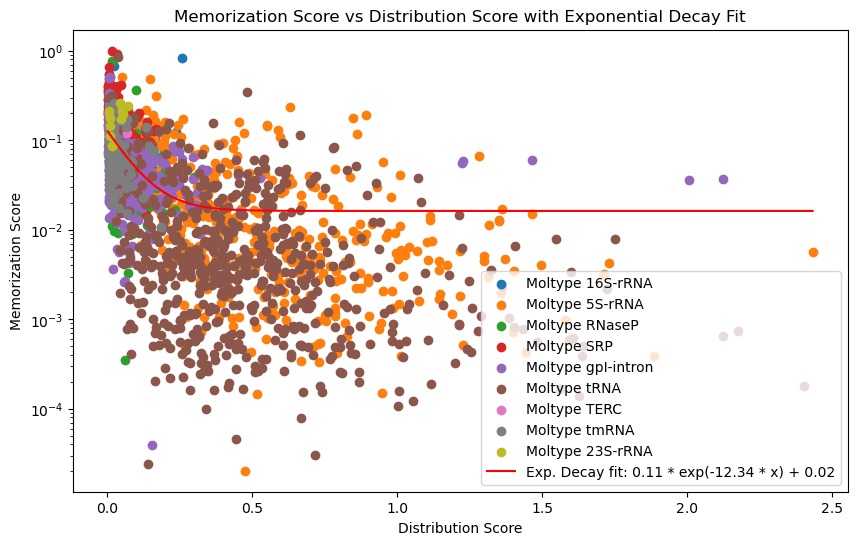

The exponential decay equation is: y = 0.11 * e^(-12.34 * x) + 0.02


In [6]:
memscore_df['idx'] = memscore_df['idx'].astype(str) #ensuring both dataframes have the same data type for the idx column
similarity_scores_df['idx'] = similarity_scores_df['idx'].astype(str)

# Merging the two dataframes so each idx has a memorization score and a similarity score
merged_df = pd.merge(memscore_df, similarity_scores_df, on='idx', how='inner')
def exp_decay(x, a, b, c): # Exponential decay function to fit the data
    return a * np.exp(-b * x) + c

# Fitting data
x = merged_df['similarity_score']
y = merged_df['Memorization_Score']
initial_guess = [1, 1, 1]  # Initial guess for parameters a, b, c
params, covariance = curve_fit(exp_decay, x, y, p0=initial_guess)
x_fit = np.linspace(min(x), max(x), 500) # Generate x values for the fitted curve
y_fit = exp_decay(x_fit, *params)
moltypes = merged_df['moltype'].unique()  # Get unique moltypes
color_map = {moltype: color for moltype, color in zip(moltypes, plt.cm.tab10.colors[:len(moltypes)])}


# Plotting
plt.figure(figsize=(10, 6))
for moltype in moltypes:
    subset = merged_df[merged_df['moltype'] == moltype]
    plt.scatter(subset['similarity_score'], subset['Memorization_Score'],
                color=color_map[moltype], label=f'Moltype {moltype}')
plt.plot(x_fit, y_fit, color='red', label=f'Exp. Decay fit: {params[0]:.2f} * exp(-{params[1]:.2f} * x) + {params[2]:.2f}')
plt.xlabel('Distribution Score')
plt.ylabel('Memorization Score')
plt.yscale('log')
plt.title('Memorization Score vs Distribution Score with Exponential Decay Fit')
plt.legend()
plt.show()
print(f'The exponential decay equation is: y = {params[0]:.2f} * e^(-{params[1]:.2f} * x) + {params[2]:.2f}')


### Graphing the relationship between simmilarity score and memorization score as an exponential decay function for Levenshtein

/Users/ilanastern/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


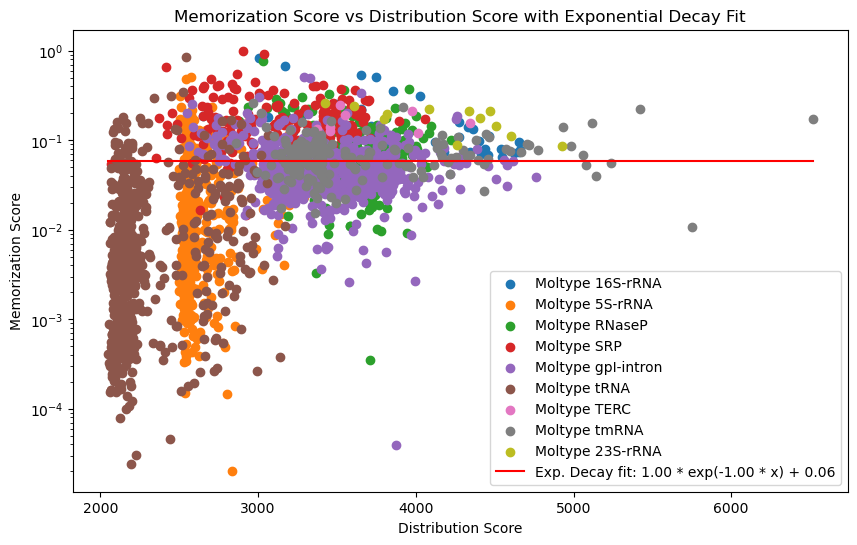

The exponential decay equation is: y = 1.00 * e^(-1.00 * x) + 0.06


In [7]:
memscore_df['idx'] = memscore_df['idx'].astype(str) #ensuring both dataframes have the same data type for the idx column
similarity_scores_2_df['idx'] = similarity_scores_2_df['idx'].astype(str)

# Merging the two dataframes so each idx has a memorization score and a similarity score
merged_df = pd.merge(memscore_df, similarity_scores_2_df, on='idx', how='inner')
def exp_decay(x, a, b, c): # Exponential decay function to fit the data
    return a * np.exp(-b * x) + c

# Fitting data
x = merged_df['similarity_score']
y = merged_df['Memorization_Score']
initial_guess = [1, 1, 1]  # Initial guess for parameters a, b, c
params, covariance = curve_fit(exp_decay, x, y, p0=initial_guess)
x_fit = np.linspace(min(x), max(x), 500) # Generate x values for the fitted curve
y_fit = exp_decay(x_fit, *params)
moltypes = merged_df['moltype'].unique()  # Get unique moltypes
color_map = {moltype: color for moltype, color in zip(moltypes, plt.cm.tab10.colors[:len(moltypes)])}


# Plotting
plt.figure(figsize=(10, 6))
for moltype in moltypes:
    subset = merged_df[merged_df['moltype'] == moltype]
    plt.scatter(subset['similarity_score'], subset['Memorization_Score'],
                color=color_map[moltype], label=f'Moltype {moltype}')
plt.plot(x_fit, y_fit, color='red', label=f'Exp. Decay fit: {params[0]:.2f} * exp(-{params[1]:.2f} * x) + {params[2]:.2f}')
plt.xlabel('Distribution Score')
plt.ylabel('Memorization Score')
plt.yscale('log')
plt.title('Memorization Score vs Distribution Score with Exponential Decay Fit')
plt.legend()
plt.show()
print(f'The exponential decay equation is: y = {params[0]:.2f} * e^(-{params[1]:.2f} * x) + {params[2]:.2f}')


### Code for Influnce Score (takes too long to run)

In [ ]:
# Creating a pairwise matrix of every idx value
idx_list = memscore_df['idx'].unique()
pairwise_idx_df = pd.DataFrame(np.nan, index=idx_list, columns=idx_list) # Create a square DataFrame with 'idx' values as both row and column headers

tr_data = {}
vl_data = {}

# Loop through the directory 
for root, dirs, files in os.walk(data_path):
    if root.endswith('_TR.eval') or root.endswith('_VL.eval'):  
        for file in files:
            if file.startswith('eval_loss_meta'):  # Check if the file is 'eval_loss_meta'
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path) # Read the file into a DataFrame
                # Use file path as the key in the dictionary, or generate a unique key
                if root.endswith('_TR.eval'):
                    tr_data[file_path] = df  # Save df in tr_data dictionary
                elif root.endswith('_VL.eval'):
                    vl_data[file_path] = df  # Save df in vl_data dictionary

# Iterate through each row and columns in the square matrix
for row in pairwise_idx_df.index:
    for col in pairwise_idx_df.columns:
        vl_f1_without_col_value = []  # Stores VL f1 scores where col idx is NOT in TR
        vl_f1_with_col_value = []     # Stores VL f1 scores where col idx is in TR
        
        # Loop through all TR data files
        for tr_file_path, tr_df in tr_data.items():
            # Extract TR data where the 'idx' contains the row but not the col
            tr_contains_row_not_col = tr_df[(tr_df['idx'] == row) & (tr_df['idx'] != col)]
            
            # Now for each relevant TR data, find the matching VL data
            for vl_file_path, vl_df in vl_data.items():
                # Get the VL_f1 score for the idx values when the idx was NOT in the TR data
                vl_f1_row_not_col = vl_df[vl_df['idx'].isin(tr_contains_row_not_col['idx'])]['f1']
                vl_f1_without_col_value.extend(vl_f1_row_not_col.tolist())
                
                # Extract TR data when the idx is in the TR data
                tr_contains_both = tr_df[(tr_df['idx'] == row) & (tr_df['idx'] == col)]
                # Get the VL_f1 score for the idx values when the idx was in the TR data
                vl_f1_both = vl_df[vl_df['idx'].isin(tr_contains_both['idx'])]['f1']
                vl_f1_with_col_value.extend(vl_f1_both.tolist())
        
        # Compute the difference between the means of VL_f1 scores
        if vl_f1_with_col_value and vl_f1_without_col_value:  # Check if both lists have data
            influence = np.mean(vl_f1_with_col_value) - np.mean(vl_f1_without_col_value)  
        else:
            influence = np.nan  # Assign NaN if no data
        
        # enter the influence value into pairwise matrix
        pairwise_idx_df.loc[row, col] = influence